# Table of content

[1. Load and clean the CMU datasets ](#section1)

[2. Merge the datasets ](#section2)

[3. First analysis ](#section3)

> [3.1 Score ](#section3.1)
    
> [3.2 Language availability ](#section3.2)
    
> [3.3 Character name ](#section3.3)

> [3.4 Genre and release month ](#section3.4)

> [3.5 Plot summaries ](#section3.5)

> [3.6 Budgets ](#section3.6)

<a id="section1"></a>
# 1. Load and clean the CMU datasets

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import ast
from scipy import stats
import itertools
import matplotlib

import re
import spacy 
# might need to run (on terminal) : 
# - pip install spacy
# - python -m spacy download en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [59]:
'''
Importing the data : 
As all the needed csv files are small enough, we loaded them in the data folder, 
in order to have unique paths for reading the files
'''

path_cmu = 'data/MovieSummaries/'

name_clusters = pd.read_csv(path_cmu+'name.clusters.txt', delimiter='\t',header=None)
tv_tropes = pd.read_csv(path_cmu+'tvtropes.clusters.txt',delimiter='\t',header=None)
plot_summaries = pd.read_csv(path_cmu+'plot_summaries.txt',delimiter='\t',header=None)
movie_metadata = pd.read_csv(path_cmu+'movie.metadata.tsv',delimiter='\t',header=None)
character_metadata = pd.read_csv(path_cmu+'character.metadata.tsv',delimiter='\t',header=None)

In [60]:
# defining columns names for all datasets

movie_columns = ['Wikipedia_ID','Freebase_ID','movie_name','movie_release_date','revenue','runtime',
                 'language_freebase','country_freebase','genre_freebase']
movie_metadata.columns = movie_columns

character_columns = ['Wikipedia_ID','Freebase_ID','movie_release_date','char_name','birthday','gender','height_m',
                            'eth_freebase','actor_name','age_release','char_actor_map_freebase','char_freebase','actor_freebase']
character_metadata.columns = character_columns

tv_tropes_columns = ['type','trope']
tv_tropes.columns = tv_tropes_columns

names_clusters_columns = ['char_name','char_actor_map_freebase']
name_clusters.columns = names_clusters_columns

In [61]:
''' Cleaning movie_metadata'''
movie_metadata.head(3)

,Wikipedia_ID,Freebase_ID,movie_name,movie_release_date,revenue,runtime,language_freebase,country_freebase,genre_freebase
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."


In [62]:
#Cleaning the data for language, genre and country columns

def extract(id_tuple):
    input_dict = ast.literal_eval(id_tuple)
    second_elements = list(input_dict.values())
    return second_elements  # Join the second elements into a single string

def clean_empty(input_list):
    if len(input_list) == 0:
        return np.nan
    else:
        return input_list
    
# for each genre, country and language column : create a column that just gives the language/genre/country without the freebase id    
movie_metadata['genre'] = movie_metadata['genre_freebase'].apply(extract)
movie_metadata['language'] = movie_metadata['language_freebase'].apply(extract)
movie_metadata['country'] = movie_metadata['country_freebase'].apply(extract)

movie_metadata = movie_metadata.drop(columns=['language_freebase', 'country_freebase','genre_freebase'])

# remove the empty values (empty list of country/language or genre) : if list is empty, replace it with NaN values and then drop NaN values
movie_metadata['genre'] = movie_metadata['genre'].apply(clean_empty)
movie_metadata['language'] = movie_metadata['language'].apply(clean_empty)
movie_metadata['country'] = movie_metadata['country'].apply(clean_empty)

movie_metadata = movie_metadata.dropna(subset = ['genre', 'language', 'country'])

                                     
# Cleaning the language column, ex: [English Language, Russian language] becomes [English, Russian]
def clean_language(input_strs):
    clean_strs = []
    for i in range(len(input_strs)):
        clean_str = input_strs[i].split('Language')[0].strip()
        clean_str = clean_str.split('language')[0].strip()
        clean_strs.append(clean_str)
    return clean_strs

movie_metadata['language'] = movie_metadata['language'].apply(clean_language)


movie_metadata.head(3)

,Wikipedia_ID,Freebase_ID,movie_name,movie_release_date,revenue,runtime,genre,language,country
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",[English],[United States of America]
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"[Mystery, Biographical film, Drama, Crime Drama]",[English],[United States of America]
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"[Crime Fiction, Drama]",[Norwegian],[Norway]


In [63]:
nan_percentage_movie = (movie_metadata.isna().sum() / len(movie_metadata)) * 100
print("Percnateg of NaN values in the movie_metadata set :\n", nan_percentage_movie)

Percnateg of NaN values in the movie_metadata set :
 Wikipedia_ID           0.000000
Freebase_ID            0.000000
movie_name             0.000000
movie_release_date     3.690238
revenue               87.450069
runtime               18.757022
genre                  0.000000
language               0.000000
country                0.000000
dtype: float64


We see that the biggest percentage of missing values in our movie data is in the 'revenue' column. We have therefore decided to not use this data as a succes standard continuing with our analysis since it will restrict our data points too much. Instead, we decided to work with IMDB ratingsa instead.

In [64]:
movie_metadata = movie_metadata.drop(columns=['revenue'])

In [65]:
nan_percentage_character = (character_metadata.isna().sum() / len(character_metadata)) * 100
print("Percnateg of NaN values in the character_metadata set :\n", nan_percentage_character)

Percnateg of NaN values in the character_metadata set :
 Wikipedia_ID                0.000000
Freebase_ID                 0.000000
movie_release_date          2.217814
char_name                  57.220488
birthday                   23.552763
gender                     10.120288
height_m                   65.645740
eth_freebase               76.466542
actor_name                  0.272484
age_release                35.084064
char_actor_map_freebase     0.000000
char_freebase              57.218269
actor_freebase              0.180842
dtype: float64


One of our first idea was to analyse wether diversity impact a movie success or no. That idea would imply that we run analysis on gender, age and ethnicity. But, as 75% of ethnicity values are null, we decided to drop that idea because we were afraid that our results would not be enough relevant.

<a id="section2"></a>
# 2. Merge the datasates
# 2.1 : movie_ratings dataset

Merge movie_metadata with IMDB ratings (using first a merge with the map of IMDB id and Freebase id)

In [66]:
#Loading IMDB ID data
imdb_map_id = pd.read_csv('data/query.tsv',delimiter='\t')
imdb_map_id = imdb_map_id.drop_duplicates(keep = 'first')


# Same name as in movie_metadata
imdb_map_id=imdb_map_id.rename(columns={"freebaseID": "Freebase_ID"})
imdb_map_id=imdb_map_id.drop(columns=['item'])

# Merging movie_metadata with IMDB ID
movie_imdb = movie_metadata.merge(imdb_map_id, how='inner',on=['Freebase_ID'])

In [67]:
#Loading IMDB rating data

imdb_rating = pd.read_csv('data/ratings.tsv',delimiter='\t')
imdb_rating = imdb_rating.rename(columns={"tconst": "imdbID"})

# Merging movie data with IMDB ratings
movie_rating = movie_imdb.merge(imdb_rating,how='inner',on=['imdbID'])

Creation of a weighted score : 

We have both ratings and number of votes. We need to balance ratings with votes. Indeed, a movie with a rating of 7.5 but 
only 50 votes, for example, should be considered less popular than a movie with a lower ratings (6.5) but with 20'000 votes.
That is why we mutliply by the log of the votes, so that a rating has more weight if it has more votes. 
The rate of the weight slows down as the number of votes becomes very high (for very popular movie), so we do not end up with super high score.

In [68]:
movie_rating['weighted_score'] = movie_rating['averageRating'] * np.log(movie_rating['numVotes'] + 1)

print("The minimum weighted rating is : ",movie_rating['weighted_score'].min())
print("The maximum weighted rating is : ", movie_rating['weighted_score'].max())
movie_rating.head(3)

The minimum weighted rating is :  3.113456238488501
The maximum weighted rating is :  138.11975525257873


,Wikipedia_ID,Freebase_ID,movie_name,movie_release_date,runtime,genre,language,country,imdbID,averageRating,numVotes,weighted_score
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",[English],[United States of America],tt0228333,4.9,56928,53.652845
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,95.0,"[Mystery, Biographical film, Drama, Crime Drama]",[English],[United States of America],tt0245916,6.0,69,25.490971
2,28463795,/m/0crgdbh,Brun bitter,1988,83.0,"[Crime Fiction, Drama]",[Norwegian],[Norway],tt0094806,5.6,41,20.930950


# 2.2 : movie_ratings_budget dataset

In [70]:
''' budgets data set cleaning '''

#specified low_memory to False because warning was given that column 10 had mixed types
kaggle_movies = pd.read_csv('data/Kaggle/movies_metadata.csv', low_memory=False)

budgets = kaggle_movies[['imdb_id','budget']].copy()

def to_numeric(x):
    if x.isnumeric():
        return x
    else:
        return "0"

# put every non-numeric values to "0", then drop all values 0 for budget
budgets['budget'] = budgets['budget'].apply(to_numeric)  
budgets['budget'] = budgets['budget'].apply(int)  

budgets.loc[budgets['budget'] == 0, 'budget'] = np.nan
budgets = budgets.dropna(subset = ['budget'])

In [71]:
''' budgets dataset merging '''

budgets = budgets.rename(columns={"imdb_id": "imdbID"})
movie_ratings_budgets = movie_rating.merge(budgets,how='inner',on=['imdbID'])
movie_ratings_budgets.head(3)

,Wikipedia_ID,Freebase_ID,movie_name,movie_release_date,runtime,genre,language,country,imdbID,averageRating,numVotes,weighted_score,budget
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",[English],[United States of America],tt0228333,4.9,56928,53.652845,28000000.0
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,106.0,"[Musical, Comedy, Black-and-white]",[English],[United States of America],tt0029852,6.8,2268,52.544242,2000000.0
2,171005,/m/016ywb,Henry V,1989-11-08,137.0,"[Costume drama, War film, Epic, Period piece, ...",[English],[United Kingdom],tt0097499,7.5,31208,77.613463,9000000.0


# 2.3 movie_character and movie_character_name datasets: 
Merging of movie_metadata and character_metadata  

Merging of movie_character and name_clusters

In [72]:
print(len(name_clusters['char_name'].unique()))

970


In [73]:
movie_character = movie_rating.merge(character_metadata, how='inner', on=['Freebase_ID','Wikipedia_ID','movie_release_date'])
movie_character_name = movie_character.merge(name_clusters, how='inner', on =['char_actor_map_freebase','char_name'])
#character_name.drop_duplicates(subset = ['char_name'], keep = 'first', inplace = True) 

print(len(movie_character_name['char_name'].unique()))

965


After merging the dataframes, we lose data on 5 of the characters.

In [74]:
name_cluster_analysis = movie_character_name[['Freebase_ID', 'movie_name','char_name','averageRating','numVotes','weighted_score']].copy()

<a id="section3"></a>
# 3. First analysis

<a id="section3.1"></a>
# 3.1 Score

Let's make basic visualization of our score distribution. That will allow us to have a better undertsanding of what is a common score, a good one, ect.

<Axes: >

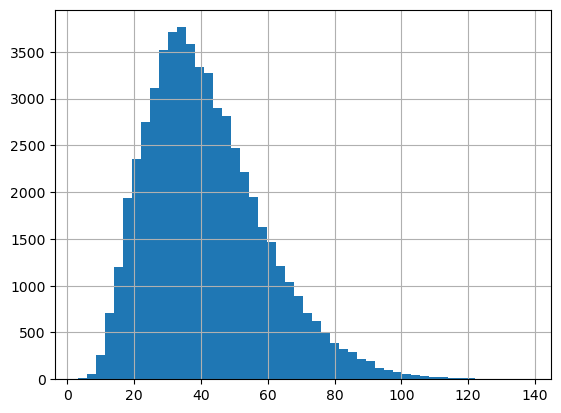

In [15]:
movie_rating['weighted_score'].hist(bins = 50)

Most movies seem to have a score between 30-50. We can consider in the following a score of 20, for example, as not really good, and a score of 60 as really good.

<a id="section3.2"></a>
# 3.2 Language availability

* language distribution

We look at the 10 most used languages, and how their use is distributed

In [27]:

''' 
As we have lists of languages, because a movie can have mutliple languages, we cannot directly count each time one 
language is used. 
To do that, we first have to flatten the column ("explode" it : if a movie has n languages: l1,...,lncreate n rows where 
row i has language li). 
Then, for each language we count the number of time it appears and we keep the 10 highest.
'''

exploded_languages_data = movie_rating.explode('language')
top_languages_count = exploded_languages_data['language'].value_counts().head(10) #.index.tolist()

In [28]:
''' same color-language mapping for both bar and pie charts ''' 

colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'brown', 'pink']

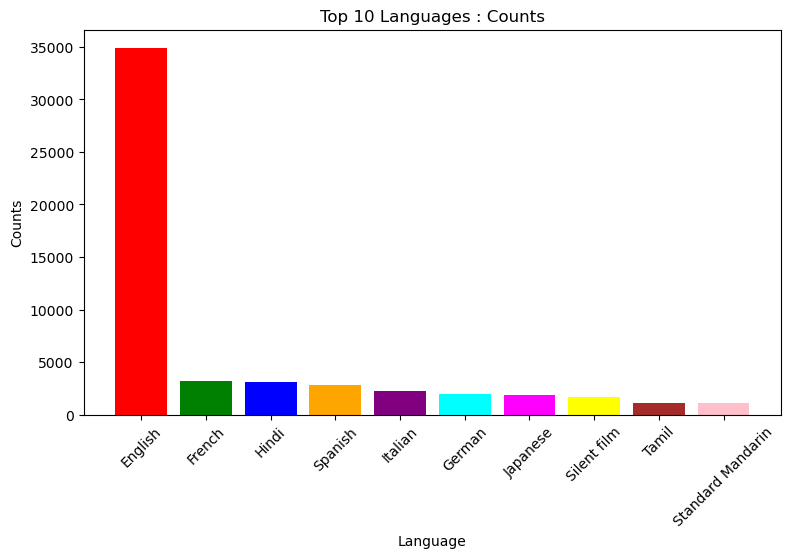

In [29]:
'''bar plot '''
plt.figure(figsize=(9, 5))

plt.bar(top_languages_count.index, top_languages_count.values, color=colors)

plt.xlabel('Language')
plt.ylabel('Counts')
plt.title('Top 10 Languages : Counts')
plt.xticks(rotation=45)
plt.show()

We can also plot the results in a pie chart, to have a better idea of the distribution of the languages (with percentage of use)

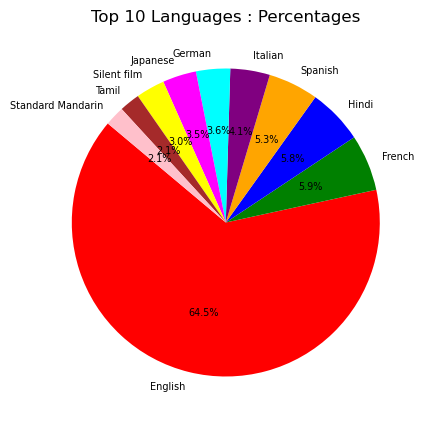

In [30]:
''' pie chart '''
plt.figure(figsize=(5, 5))

plt.pie(top_languages_count.values, labels = top_languages_count.index, autopct='%1.1f%%',textprops={'fontsize': 7}, colors = colors, startangle=140)
plt.title('Top 10 Languages : Percentages')

plt.show()

* relation between languages and countries.

Now, we look at the relation between the movie's languages and the country the movie is from.

In [39]:
'''
As a movie can also come from mutliple countries, like we did for the languages, we explode the country columns.
'''

exploded_languages_countries_data = exploded_languages_data.explode('country').reset_index() # so we do not have duplicate indexes
exploded_languages_countries_data
languages = exploded_languages_countries_data['language']
countries = exploded_languages_countries_data['country']

Now that our data is ready, we create a contugency table to help us plot the resulting distribution.

In [42]:
''' 
We only take 200 rows, otherwise if we take the whole data, the plot is illisible.
Taking 200 data points for now will still give us an idea of the distribution.
'''
contigency_table = pd.crosstab(languages[:200], countries[0:200])

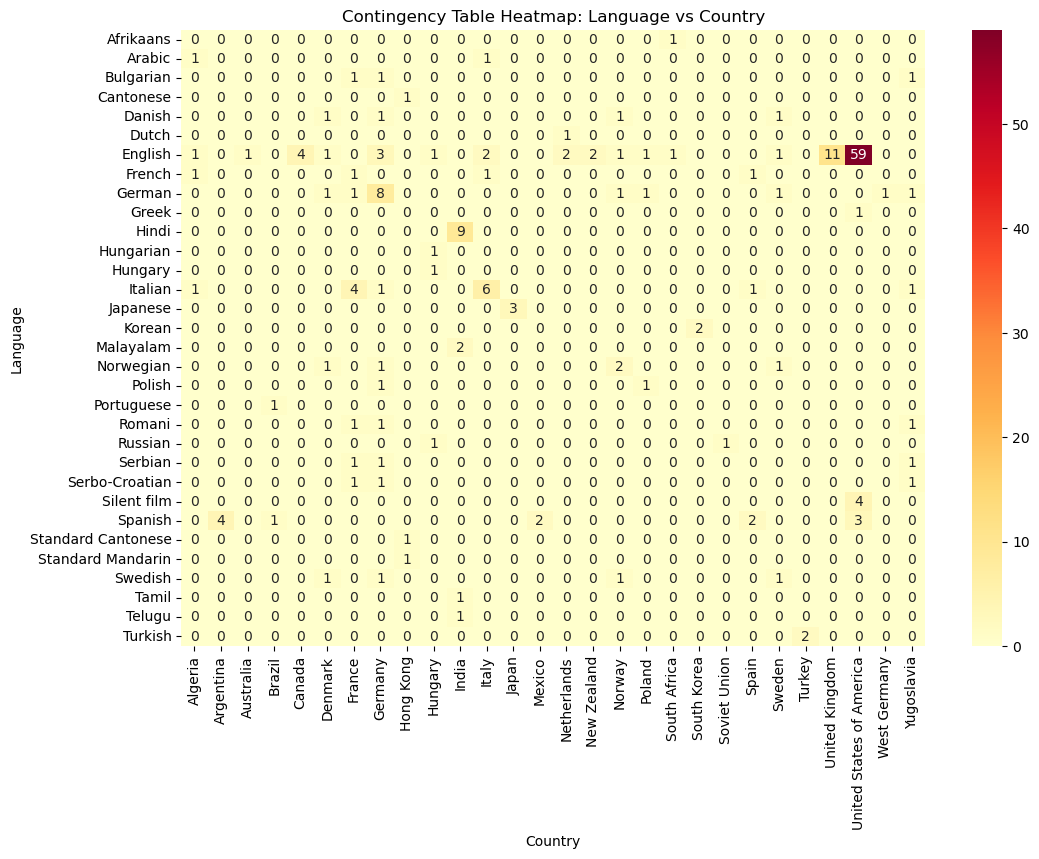

In [43]:
plt.figure(figsize=(12, 8))
sns.heatmap(contigency_table, annot=True, cmap="YlOrRd") # Purples good too
plt.title('Contingency Table Heatmap: Language vs Country')
plt.ylabel('Language')
plt.xlabel('Country')
plt.show()

* goal analysis

We clearly saw that English is (by far) the language the most available. Also, most movies available in English seem to come from the United States of America (and United Kingdom) (based on the heatmap). 

As we know, English is the language the most spoken in the world, so English avalability might have an impact on the succes and/or popularity of a movie.
We will focus our future analysis on that.

For that, we will try to build 2 different categories of movies:

- the one that are avalaible in at least English and 1 (any) other language (and that does not come from the USA or United Kindgom)
- the one not avalaible in English (and that does not come the USA or United Kingdom)

We will then analyse and compare their success. And with the results, evaluate the impact of English availability on a movie's success.

<a id="section3.3"></a>
# 3.3 Character name

* Interactive visualisation of the number of times a character name is in a movie

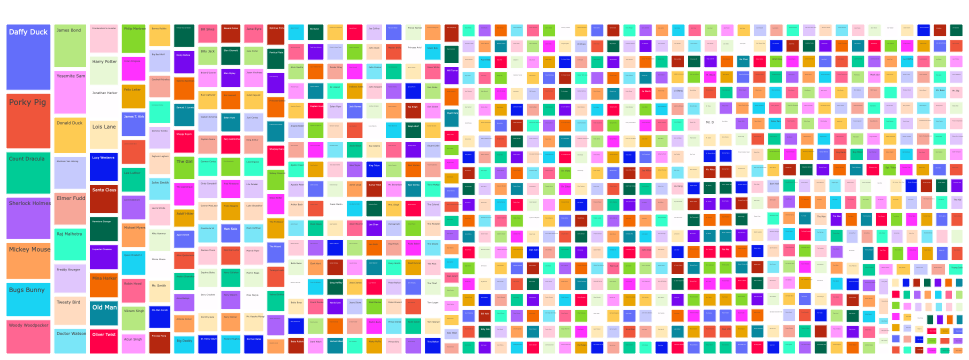

In [62]:
#How many times each character has data about them

character_counts = name_cluster_analysis.groupby('char_name').size().reset_index(name='char_counts')

#In how many movies is each character present
fig = px.treemap(character_counts, path=['char_name'],values='char_counts')
fig.update_layout(margin=dict(t=0, l=0, r=0, b=0))
fig.show()

- Effect of seeing a character in more than one movie on movie ratings

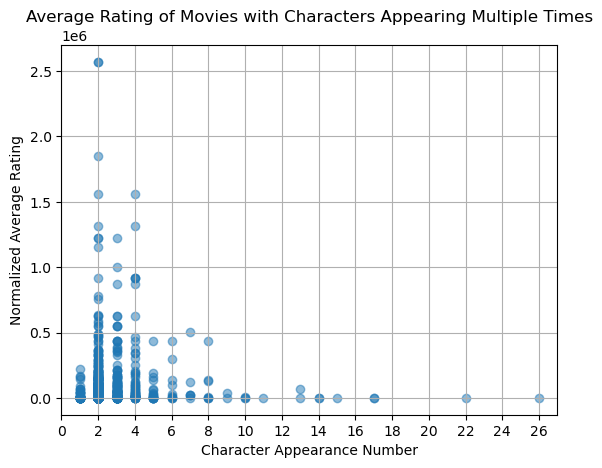

In [63]:
#Merge the character counts to name_clusters analysis

character_name = name_cluster_analysis.merge(character_counts,how='inner',on=['char_name']).copy()
character_name.drop_duplicates(subset = ['char_name'], keep = 'first', inplace = True) 

plt.scatter(character_name['char_counts'], character_name['averageRating_normalized'], alpha=0.5)
plt.title('Average Rating of Movies with Characters Appearing Multiple Times')
plt.xlabel('Character Appearance Number')
plt.xticks(np.arange(0, character_name['char_counts'].max() + 1, 2))
plt.xlim(0, character_name['char_counts'].max()+1)
plt.ylabel('Normalized Average Rating')
#plt.ylim(0,100000)
plt.grid(True)
plt.show()

<a id="section3.4"></a>
# 3.4 Genre and release month

In [75]:
movie_rating['movie_release_date'].head(10)

0    2001-08-24
1    2000-02-16
2          1988
3          1987
4          1983
5    1913-05-29
6    1938-08-16
7          1960
8          1930
9          1974
Name: movie_release_date, dtype: object

We see that there is some dates where only the year is given and some where we have the whole date (year-month-day). We need to have a unique format in order to perform our analysis. But we also need the month to evaluate the success of a movie based on its genre and the month it was released. So we should only keep data where we have the whole date.

Let's look at the precentage of the unusable dates (the one that does not have the month given).

In [76]:
unusable_data = (movie_rating['movie_release_date'].str.len() < 5).sum()

unusable_data_percentage = (unusable_data / len(movie_rating['movie_release_date'])) * 100
print("The percentage of data that we are not able to use is : ",unusable_data_percentage)

The percentage of data that we are not able to use is :  38.816929591052826


As can be seen, about 39% of the data is not usable. We decide to remove those and continue with the rest of the data. (39% is quite big, but as our dataset is also big, that still leaves us with about 32 000 data, which seems enough to run our analysis (see the shape print in the next cell)).

In [77]:
movie_rating_clean_year = movie_rating[movie_rating['movie_release_date'].str.len() >= 5].copy()
print("The number of data left is : ", movie_rating_clean_year.shape[0])
movie_rating_clean_year.head(3)

The number of data left is :  32470


,Wikipedia_ID,Freebase_ID,movie_name,movie_release_date,runtime,genre,language,country,imdbID,averageRating,numVotes,weighted_score
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",[English],[United States of America],tt0228333,4.9,56928,53.652845
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,95.0,"[Mystery, Biographical film, Drama, Crime Drama]",[English],[United States of America],tt0245916,6.0,69,25.490971
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,35.0,"[Short Film, Silent film, Indie, Black-and-whi...","[Silent film, English]",[United States of America],tt0002894,6.8,17,19.654528


Now that the we only have usable data left, we create an extra column, where only the month is given of each movie.

In [78]:
# Extra column where the month is given. 
movie_rating_clean_year['release_month'] = pd.to_datetime(movie_rating_clean_year['movie_release_date'], errors='coerce').dt.month
movie_rating_clean_year.head(3) 

,Wikipedia_ID,Freebase_ID,movie_name,movie_release_date,runtime,genre,language,country,imdbID,averageRating,numVotes,weighted_score,release_month
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",[English],[United States of America],tt0228333,4.9,56928,53.652845,8.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,95.0,"[Mystery, Biographical film, Drama, Crime Drama]",[English],[United States of America],tt0245916,6.0,69,25.490971,2.0
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,35.0,"[Short Film, Silent film, Indie, Black-and-whi...","[Silent film, English]",[United States of America],tt0002894,6.8,17,19.654528,5.0


Now, we will make first analysis on relation between success and ratings by plotting it on heatmap

In [79]:
''' Again, a movie can have mutliple genre, so we explode the column. '''
exploded_genre_data = movie_rating_clean_year.explode('genre')

In [107]:
def create_heatmap(data, save_name, fig_size):
    # Group data by month and genre
    grouped_data = data.groupby(['release_month', 'genre'])

    # Calculate average rating for each genre in each month
    avg_ratings = grouped_data['weighted_score'].mean().reset_index()

    # Pivot the data for visualization
    pivot_data_all = avg_ratings.pivot(index = 'release_month', columns = 'genre', values ='weighted_score')

    # Plot the data
    plt.figure(figsize=(fig_size[0], fig_size[1]))
    sns.heatmap(pivot_data_all, cmap='YlOrRd', annot=True, fmt=".2f", cbar_kws={'label': 'Average Score'})
    plt.title('Average Score of Genres by Month')
    plt.xlabel('Genre')
    plt.ylabel('Month')
    plt.show()
    plt.savefig('figure/' + save_name)

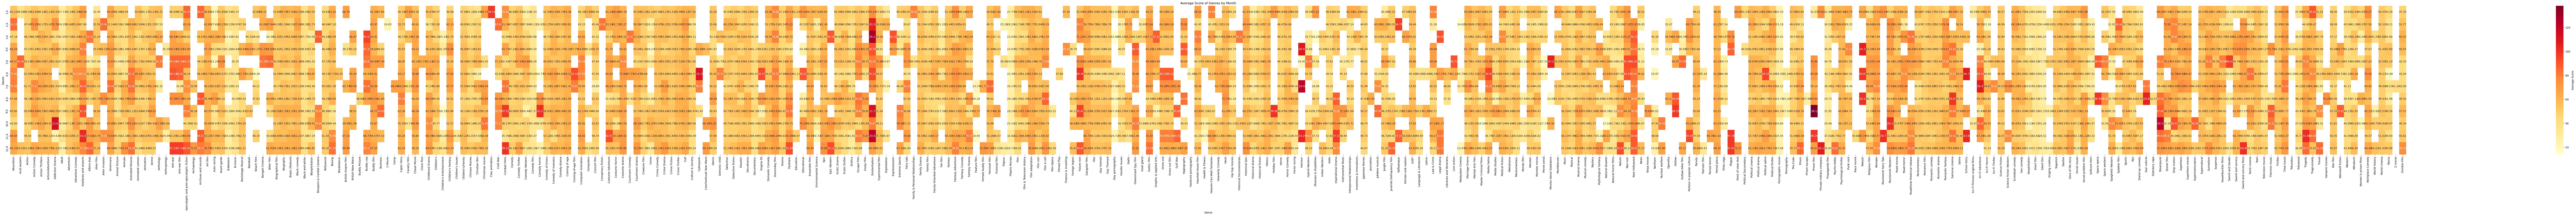

<Figure size 640x480 with 0 Axes>

In [108]:
#PLOT 1 : plotting all the data

create_heatmap(data = exploded_genre_data, save_name = 'genre_month_heatmap.png', fig_size = (200,10))

We have a lot of data, hence the heatmap is not readible like that without zooming. In order to have a more readible heatmap on the notebook, we look for the 20 more used genres. Then we only keep the data with these genre and replot the heatmap. 

(Note: this plot is still saved in the figure directory)

In [109]:
# compute a list of the 20 most common genres

top_genres = exploded_genre_data['genre'].value_counts().head(20).index.tolist()
exploded_data_main_genre = avg_ratings[avg_ratings['genre'].isin(top_genres)]

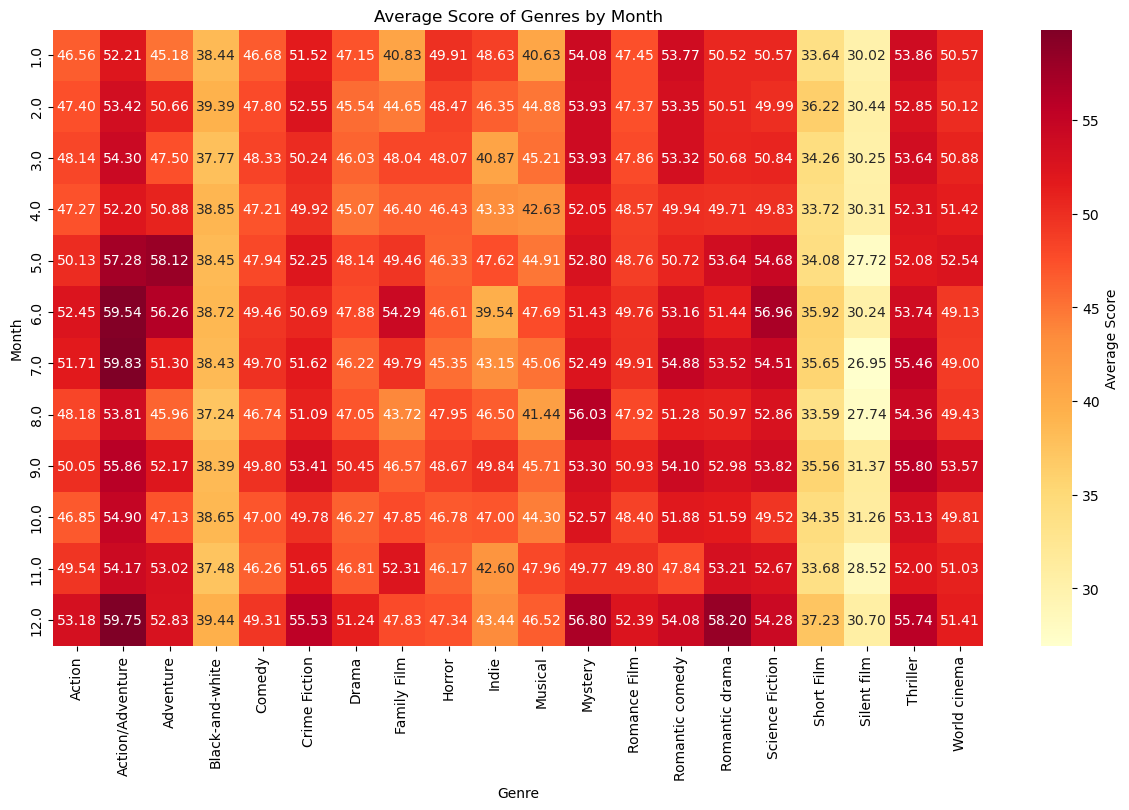

<Figure size 640x480 with 0 Axes>

In [110]:
# PLOT 2 : plotting a-only the data with genre in the top 20

create_heatmap(data = exploded_data_main_genre, save_name = '20genres_month_heatmap.png', fig_size = (15,8))

We can already see that there is some genre that seem to perform better when they are released in certain month, and even some month in general that seems to have better score. This is what we will keep exploring and analysing.

<a id="section3.5"></a>
# 3.5 Plot summaries

* Preprocessing

In [82]:
file_path = 'data/MovieSummaries/plot_summaries.txt'

#regular expression pattern to extract id and movieplot
#(This is due to the format of the file: There is either a tab or some whitespaces between id and movieplot)
pattern = re.compile(r'(\d+)\s+(.*)')

# Initializing lists to store id and movieplot data
ids = []
movieplots = []

# Reading the file line by line and extracting id and movieplot using regular expression
with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        match = pattern.match(line)
        if match:
            ids.append(int(match.group(1)))
            movieplots.append(match.group(2))

df = pd.DataFrame({'id': ids, 'movieplot': movieplots})
print(df)

             id                                          movieplot
0      23890098  Shlykov, a hard-working taxi driver and Lyosha...
1      31186339  The nation of Panem consists of a wealthy Capi...
2      20663735  Poovalli Induchoodan  is sentenced for six yea...
3       2231378  The Lemon Drop Kid , a New York City swindler,...
4        595909  Seventh-day Adventist Church pastor Michael Ch...
...         ...                                                ...
42301  34808485  The story is about Reema , a young Muslim scho...
42302   1096473  In 1928 Hollywood, director Leo Andreyev  look...
42303  35102018  American Luthier focuses on Randy Parsons’ tra...
42304   8628195  Abdur Rehman Khan , a middle-aged dry fruit se...
42305   6040782  1940 - Operation Dynamo has just taken place. ...

[42306 rows x 2 columns]


In [83]:
#We only use a subset of the data for demonstration purposes and to save computation time
#in final assignment we will use the entire dataset
copy = df.head(1000).copy()

#Removing all places in file where there is {{.*}} in the text
#This is because the file contains things like {{plot}} and {{Expand section}} which can affect our analysis
regex = r"\{\{.*?\}\}"
copy['movieplot'] = copy['movieplot'].apply(lambda x: re.sub(regex, "", x))

In [85]:
# Load spaCy English language model
nlp = spacy.load("en_core_web_sm")

In [86]:
def preprocess_text(text):
    # Converting to lowercase
    text = text.lower()

    # Removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Removing numbers
    text = re.sub(r'\d+', '', text)

    # Lemmatization using spaCy
    sentence = nlp(text)
    words = [word.lemma_ for word in sentence]

    # Removing stopwords
    words = [word for word in words if word not in STOP_WORDS]

    # Rejoining the tokens into a single string
    result = ' '.join(words)

    return result

#apply the function to the movieplot column
copy['movieplot'] = copy['movieplot'].apply(lambda x: preprocess_text(x))

* Feature exctraction

In [112]:
#Creating a bag of words matrix of the text data
#This is done using the CountVectorizer class from scikit-learn

vectorizer = CountVectorizer()

# Fit and transform the "movieplot" column
bow_representation = vectorizer.fit_transform(copy['movieplot'])

# Convert the BoW representation to a DataFrame
bow_df = pd.DataFrame(bow_representation.toarray(), columns=vectorizer.get_feature_names_out())

# Concatenate the "id" column with the BoW DataFrame
result_df = pd.concat([copy['id'], bow_df], axis=1)

# Printing the result
print("DataFrame with Bag of Words Representation:")
print("Shape:", result_df.shape)
result_df.head(5)

DataFrame with Bag of Words Representation:
Shape: (1000, 18824)


,id,aaj,aakash,aaliya,aaliyas,aame,aandava,aaron,aarti,aaya,...,zunarj,zurg,zurich,zurta,zwaiter,zwick,zwieback,zygmunt,éliane,étienne
0,23890098,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,31186339,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20663735,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2231378,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,595909,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


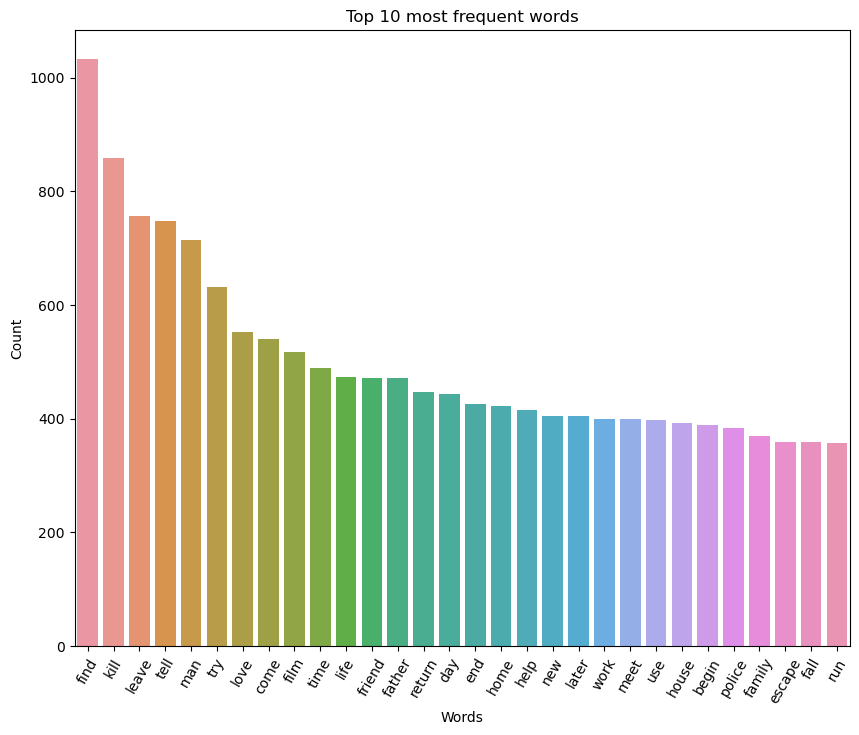

In [88]:
# Creating a DataFrame with the top words
top_x_words = pd.DataFrame(bow_df.sum().sort_values(ascending=False).head(30), columns=['count'])

plt.figure(figsize=(10, 8))
sns.barplot(x=top_x_words.index, y=top_x_words['count'])
plt.xticks(rotation=60)
plt.xlabel("Words")
plt.ylabel("Count")
plt.title("Top 10 most frequent words")
plt.show()

In [89]:
#Merging with movie_rating

#First changing name of id column to match the one in movie_rating: Wikipedia_ID
result_df=result_df.rename(columns={"id": "Wikipedia_ID"})

#Merging with movie_rating keeping only the movies that are in both dataframes
merged = movie_rating.merge(result_df,how='inner',on=['Wikipedia_ID'])

#checking shape
print(merged.shape) #We lose some rows as the inner merge only includes the movies that are in both dataframes. However, it is not too many

#extracting target column
target_column = merged['averageRating']

#removing first 11 columns as we only want to keep the bag of words columns
merged = merged.iloc[:,11:]

(803, 18835)


In [90]:
#Simple modeling
X_train, X_test, y_train, y_test = train_test_split(merged, target_column, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
word_importance = pd.DataFrame({'Word': merged.columns, 'Coefficient': model.coef_})
# Sort words by importance
word_importance = word_importance.sort_values(by='Coefficient', ascending=False)

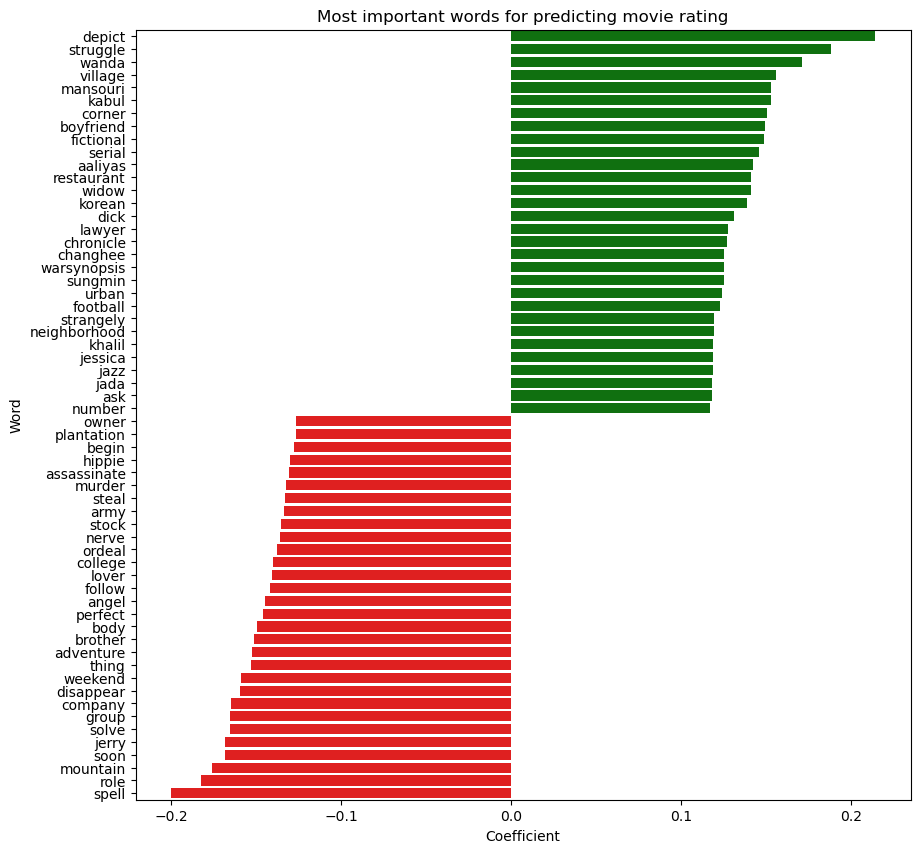

In [91]:
most_positive_words = word_importance.head(30)
most_negative_words = word_importance.tail(30)

combine = pd.concat([most_positive_words, most_negative_words])

plt.figure(figsize=(10, 10))
colors = ['green' if c > 0 else 'red' for c in combine['Coefficient']]
sns.barplot(x=combine['Coefficient'], y=combine['Word'], palette=colors)
plt.xlabel("Coefficient")
plt.ylabel("Word")
plt.title("Most important words for predicting movie rating")
plt.show()

* Next steps

This analysis was done on a small subset of the data and by using a very simple model. Also the model has not been tested on effectivness of predicting rating. Therefore the next step would be to use even more data, use a more complex model and then properly testing it.

Also we only used the plot summaries to predict, and it would therefore be relevant to test if the prediction would become more accurate if we include movie metadata like genre, language, runtime etc.

<a id="section3.6"></a>
# 3.6 Budgets